In [1]:
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

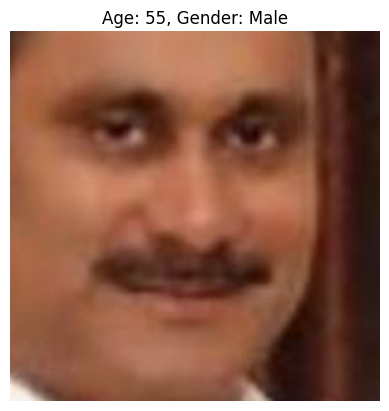

File: 55_0_3_20170104214223615.jpg.chip.jpg
Age: 55
Gender: Male


In [2]:
DATASET_DIR = "./UTKFace/UTKFace"

file_list = [f for f in os.listdir(DATASET_DIR) if f.endswith(".jpg")]

random_file = random.choice(file_list)

parts = random_file.split("_")
age = int(parts[0])
gender = "Male" if int(parts[1]) == 0 else "Female"

img_path = os.path.join(DATASET_DIR, random_file)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(f"Age: {age}, Gender: {gender}")
plt.axis('off')
plt.show()

print(f"File: {random_file}")
print(f"Age: {age}")
print(f"Gender: {gender}")

Tổng số ảnh: 23708
Số nam   : 12391
Số nữ    : 11317


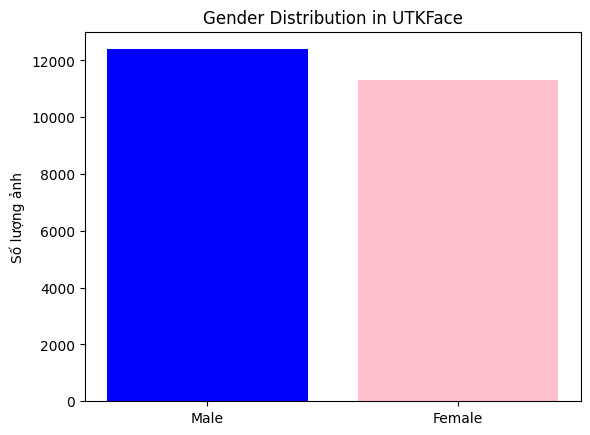

In [3]:
male_count = 0
female_count = 0

for filename in os.listdir(DATASET_DIR):
    if filename.endswith(".jpg"):
        try:
            gender = int(filename.split("_")[1])
            if gender == 0:
                male_count += 1
            elif gender == 1:
                female_count += 1
        except:
            continue
print(f"Tổng số ảnh: {male_count + female_count}")
print(f"Số nam   : {male_count}")
print(f"Số nữ    : {female_count}")

labels = ['Male', 'Female']
counts = [male_count, female_count]

plt.bar(labels, counts, color=['blue', 'pink'])
plt.title("Gender Distribution in UTKFace")
plt.ylabel("Số lượng ảnh")
plt.show()


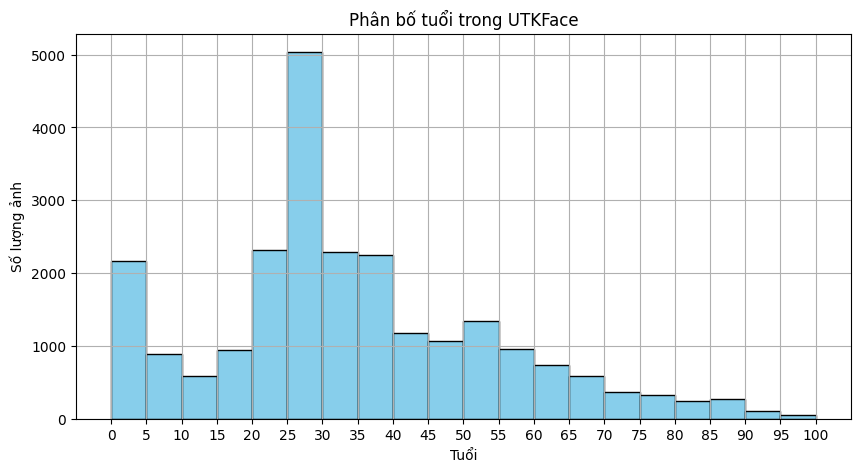

In [4]:
ages = []

for filename in os.listdir(DATASET_DIR):
    if filename.endswith(".jpg"):
        try:
            age = int(filename.split("_")[0])
            ages.append(age)
        except:
            continue  # bỏ qua file lỗi

# Vẽ biểu đồ histogram
plt.figure(figsize=(10, 5))
plt.hist(ages, bins=range(0, 101, 5), color='skyblue', edgecolor='black')
plt.title("Phân bố tuổi trong UTKFace")
plt.xlabel("Tuổi")
plt.ylabel("Số lượng ảnh")
plt.grid(True)
plt.xticks(range(0, 101, 5))
plt.show()

In [5]:
random.shuffle(file_list)

train_files, temp_files = train_test_split(file_list, test_size=0.3, random_state=42)

val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

print(f"Tổng ảnh     : {len(file_list)}")
print(f"Train ảnh    : {len(train_files)}")
print(f"Validation ảnh: {len(val_files)}")
print(f"Test ảnh     : {len(test_files)}")

Tổng ảnh     : 23708
Train ảnh    : 16595
Validation ảnh: 3556
Test ảnh     : 3557


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen(augment=False):
    if augment:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )
    else:
        return ImageDataGenerator(rescale=1./255)

train_datagen = create_datagen(augment=True)
val_datagen = create_datagen(augment=False)

In [7]:
MAX_AGE = 116

def load_and_preprocess(file_name, img_size=128):
    file_path = os.path.join(DATASET_DIR, file_name)
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"Không đọc được file ảnh: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # đổi BGR sang RGB
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32)
    return img


def extract_labels_from_filename(file_path):
    # filename có dạng: age_gender_race_date.jpg.chip.jpg
    base = os.path.basename(file_path)
    parts = base.split('_')
    age = int(parts[0])
    gender = int(parts[1])  # 0 = Male, 1 = Female
    age = age / MAX_AGE
    return gender, age

In [8]:
def multi_output_generator(file_list, datagen, batch_size=32, img_size=128, shuffle=True):
    while True:
        if shuffle:
            random.shuffle(file_list)
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i+batch_size]
            batch_images = []
            gender_labels = []
            age_labels = []

            for file in batch_files:
                img = load_and_preprocess(file, img_size)
                gender, age = extract_labels_from_filename(file)
                batch_images.append(img)
                gender_labels.append(gender)
                age_labels.append(age)

            batch_images = np.array(batch_images)
            # tăng cường dữ liệu
            batch_images_aug_iter = datagen.flow(batch_images, batch_size=len(batch_images), shuffle=False)
            batch_images_aug = next(batch_images_aug_iter)

            yield batch_images_aug, {
                'gender_output': np.array(gender_labels),
                'age_output': np.array(age_labels, dtype=np.float32)
            }

In [9]:
train_gen = multi_output_generator(train_files, train_datagen, batch_size=32, img_size=128, shuffle=True)
val_gen = multi_output_generator(val_files, val_datagen, batch_size=32, img_size=128, shuffle=False)

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 4
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Output 1: Gender (Binary classification)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

    # Output 2: Age (Regression)
    age_output = Dense(1, activation='linear', name='age_output')(x)

    # Compile model
    model = Model(inputs=inputs, outputs=[gender_output, age_output])
    model.compile(
        optimizer='adam',
        loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
        metrics={'gender_output': 'accuracy', 'age_output': 'mae'}
    )

    return model

model = build_model()
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['batch_normalization[0

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
batch_size = 32
epochs = 35
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size

train_gen = multi_output_generator(train_files, train_datagen, batch_size=batch_size)
val_gen = multi_output_generator(val_files, val_datagen, batch_size=batch_size, shuffle=False)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/35


518/518 [==============================] - 163s 309ms/step - loss: 0.7247 - gender_output_loss: 0.6000 - age_output_loss: 0.1247 - gender_output_accuracy: 0.6798 - age_output_mae: 0.2210 - val_loss: 0.7879 - val_gender_output_loss: 0.7271 - val_age_output_loss: 0.0608 - val_gender_output_accuracy: 0.5639 - val_age_output_mae: 0.2063 - lr: 0.0010
Epoch 2/35


c:\Users\01232\.conda\envs\project_dacn\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


518/518 [==============================] - 135s 261ms/step - loss: 0.5145 - gender_output_loss: 0.4841 - age_output_loss: 0.0304 - gender_output_accuracy: 0.7730 - age_output_mae: 0.1362 - val_loss: 0.5024 - val_gender_output_loss: 0.4139 - val_age_output_loss: 0.0885 - val_gender_output_accuracy: 0.8187 - val_age_output_mae: 0.2659 - lr: 0.0010
Epoch 3/35
518/518 [==============================] - 135s 261ms/step - loss: 0.4182 - gender_output_loss: 0.3944 - age_output_loss: 0.0238 - gender_output_accuracy: 0.8256 - age_output_mae: 0.1209 - val_loss: 0.5988 - val_gender_output_loss: 0.5702 - val_age_output_loss: 0.0286 - val_gender_output_accuracy: 0.7219 - val_age_output_mae: 0.1415 - lr: 0.0010
Epoch 4/35
518/518 [==============================] - 134s 259ms/step - loss: 0.3838 - gender_output_loss: 0.3639 - age_output_loss: 0.0199 - gender_output_accuracy: 0.8416 - age_output_mae: 0.1105 - val_loss: 0.3769 - val_gender_output_loss: 0.3576 - val_age_output_loss: 0.0192 - val_gender_

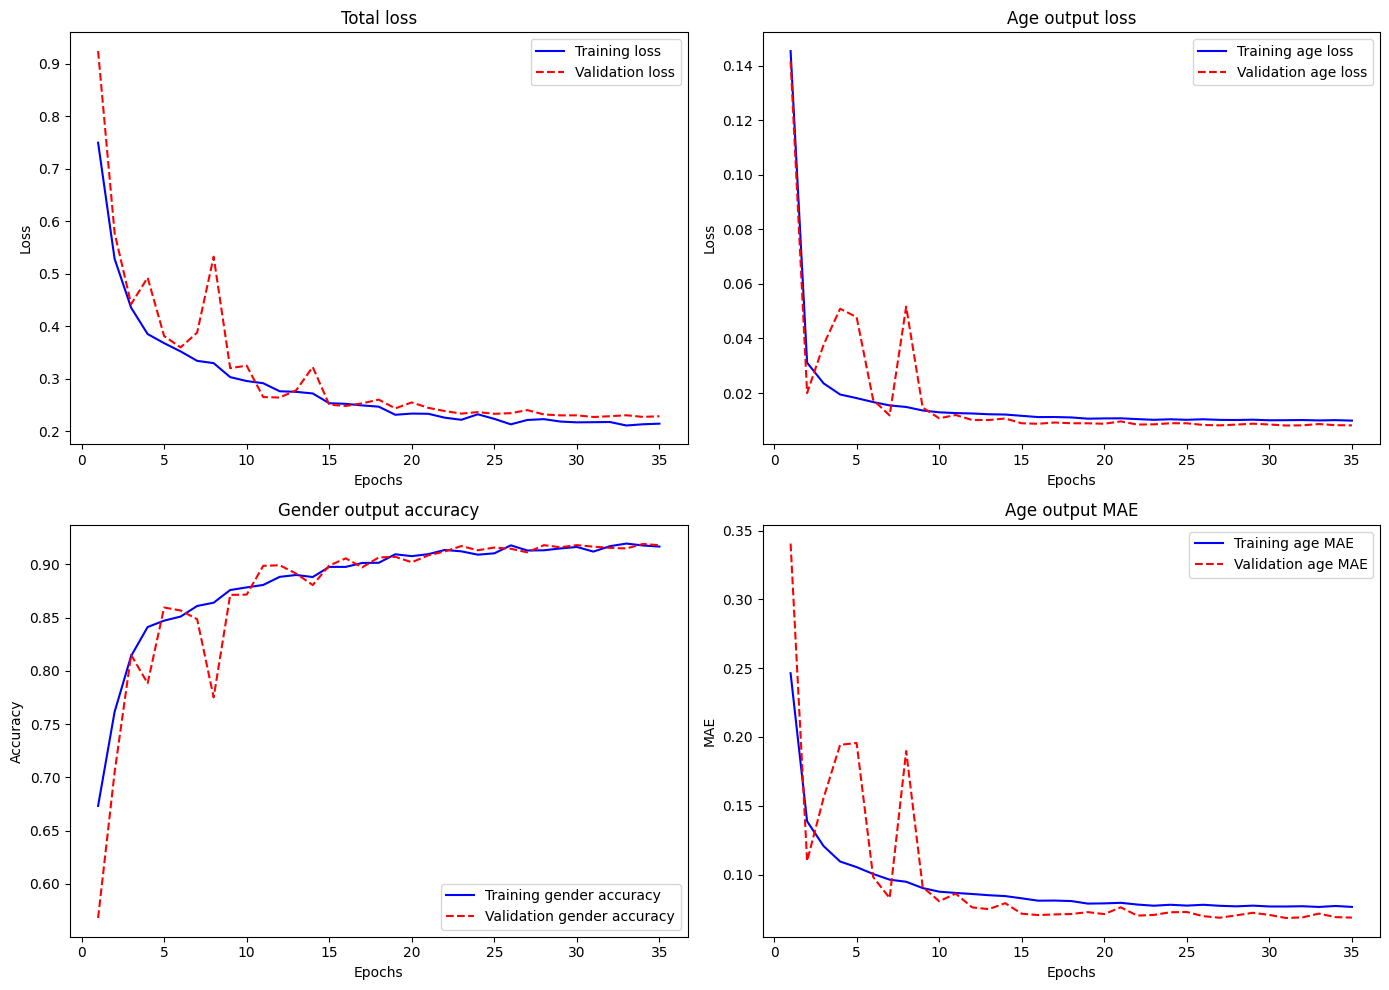

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy các giá trị lịch sử
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    age_loss = history.history['age_output_loss']
    val_age_loss = history.history['val_age_output_loss']
    gender_acc = history.history['gender_output_accuracy']
    val_gender_acc = history.history['val_gender_output_accuracy']
    age_mae = history.history['age_output_mae']
    val_age_mae = history.history['val_age_output_mae']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 10))

    # Tổng loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation loss')
    plt.title('Total loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Loss tuổi
    plt.subplot(2, 2, 2)
    plt.plot(epochs, age_loss, 'b-', label='Training age loss')
    plt.plot(epochs, val_age_loss, 'r--', label='Validation age loss')
    plt.title('Age output loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Độ chính xác giới tính
    plt.subplot(2, 2, 3)
    plt.plot(epochs, gender_acc, 'b-', label='Training gender accuracy')
    plt.plot(epochs, val_gender_acc, 'r--', label='Validation gender accuracy')
    plt.title('Gender output accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # MAE tuổi
    plt.subplot(2, 2, 4)
    plt.plot(epochs, age_mae, 'b-', label='Training age MAE')
    plt.plot(epochs, val_age_mae, 'r--', label='Validation age MAE')
    plt.title('Age output MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ sau khi train xong
plot_training_history(history)

In [ ]:
import json
import os

folder_path = './Age and Gender Detection'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)  # tạo thư mục nếu chưa có

file_path = os.path.join(folder_path, 'history.json')

# Chuyển tất cả các giá trị trong history thành float
history_data = {k: [float(x) for x in v] for k, v in history.history.items()}

with open(file_path, 'w') as f:
    json.dump(history_data, f, indent=4)


In [ ]:
model.save('./age_gender_model.h5')

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model('./age_gender_model.h5', custom_objects={'mse': MeanSquaredError()})

In [21]:
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = multi_output_generator(test_files, test_datagen, batch_size=batch_size, shuffle=False)
steps_test = len(test_files) // batch_size

results = model.evaluate(test_gen, steps=steps_test)
print("Test loss and metrics:", results)

111/111 [==============================] - 9s 79ms/step - loss: 0.1687 - gender_output_loss: 0.1613 - age_output_loss: 0.0074 - gender_output_accuracy: 0.9367 - age_output_mae: 0.0654
Test loss and metrics: [0.16869467496871948, 0.1612984985113144, 0.007396164815872908, 0.9366554021835327, 0.06535112857818604]


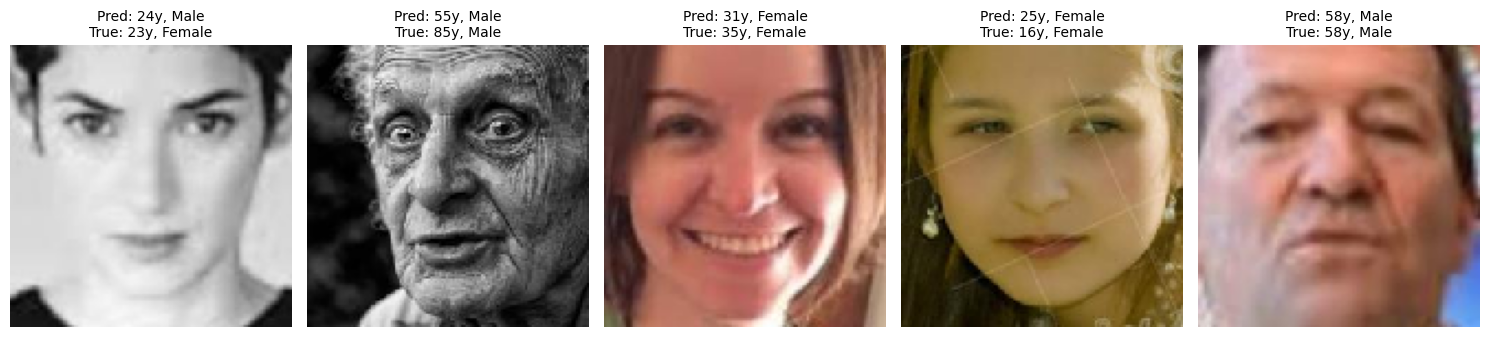

In [22]:
from tensorflow.keras.preprocessing import image

DATASET_DIR = "./UTKFace/UTKFace"
sample_files = random.sample(test_files, 5)

plt.figure(figsize=(15, 5))

for i, file_name in enumerate(sample_files):
    img_path = os.path.join(DATASET_DIR, file_name)

    try:
        age_true, gender_true = map(int, file_name.split("_")[:2])
    except Exception as e:
        print(f"Lỗi phân tích tên file {file_name}: {e}")
        continue

    gender_true_label = "Male" if gender_true == 0 else "Female"

    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred_gender, pred_age = model.predict(img_input, verbose=0)

    clamped_age = np.clip(pred_age[0][0], 0, 1)
    age_pred = clamped_age * 116 if clamped_age > 0 else 1
    age_pred = int(age_pred)
    gender_pred_label = "Male" if pred_gender[0][0] < 0.5 else "Female"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(
        f"Pred: {int(age_pred)}y, {gender_pred_label}\n"
        f"True: {age_true}y, {gender_true_label}",
        fontsize=10
    )
    plt.axis("off")

plt.tight_layout()
plt.show()
